# Seq2seq

Implementation of seq2seq model with attention from https://www.tensorflow.org/tutorials/text/nmt_with_attention

To run this notebook, you only need to have the file train.lang1 and train.lang2 in a Google Drive directory

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

#import unicodedata
import re
import numpy as np
import os
import time

TensorFlow 2.x selected.


In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [58]:
# Mounting colab with google drive
# In my Drive I have data folder containing train.lang1 and train.lang2

%cd /content/gdrive/My Drive/ift6759

/content/gdrive/My Drive/ift6759


## Preprocessing

In [0]:
# design decision included here, decided to keep é, è, ê, etc. for french 
# since otherwise it would divide a word like 'événementiel' into "v", "nementiel"

def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "é", "è", "ê", "ç", "î", "ï", "ô")
  w = re.sub(r"[^a-zA-Z?.!,¿éèçêîôï]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [16]:
fr_sentence = f"J'aime beaucoup le chocolat!"
en_sentence = f"I really like chocolate!"
print(preprocess_sentence(fr_sentence))
print(preprocess_sentence(en_sentence))

<start> j aime beaucoup le chocolat ! <end>
<start> i really like chocolate ! <end>


In [0]:
# mapping english sentences to french sentences
def combine_files(path_to_en_file, path_to_fr_file, output_path):
  with open(path_to_en_file, 'r') as en:
    with open(path_to_fr_file, 'r') as fr:
      with open(output_path, 'w') as outfile:
        en_lines = en.readlines()
        fr_lines = fr.readlines()
        for i in range(len(en_lines)):
          line = en_lines[i].strip() + '\t' + fr_lines[i]
          outfile.write(line)

In [0]:
def print_n(path_to_file, n):
  n = range(n)
  with open(path_to_file, 'r') as f:
    for i, line in enumerate(f):
      if i in n:
        print(line)

In [19]:
print('ENGLISH')
print_n('data/train.lang1', 2)

print('FRENCH')
print_n('data/train.lang2', 2)

ENGLISH
so too does the idea that accommodating religious differences is dangerous

mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be

FRENCH
L’ idée de concilier les différences religieuses semble donc dangereuse .

Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .



In [0]:
# only need to do it once, uncomment if not done
#combine_files('data/train.lang1', 'data/train.lang2', 'data/en-fr.txt')

In [21]:
# check if the combine_files function worked
print_n('data/en-fr.txt', 2)

so too does the idea that accommodating religious differences is dangerous	L’ idée de concilier les différences religieuses semble donc dangereuse .

mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be	Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .



In [0]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [0]:
en, fr = create_dataset('data/en-fr.txt', None)

In [24]:
# let's see what it outputs
print(en[-1])
print(fr[-1])

<start> i agree that we need an ambitious social agenda which will include combating poverty and social exclusion <end>
<start> je conviens que nous avons besoin d un agenda social ambitieux qui englobera la lutte contre la pauvreté et l exclusion sociale . <end>


In [0]:
def max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path='data/en-fr.txt')

In [0]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [0]:
# Creating training and validation sets using an 90-10 split, could be modified of course
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1)

In [31]:
# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

9900 9900 1100 1100


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [33]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[-1])

Input Language; index to word mapping
2 ----> <start>
122 ----> economic
303 ----> growth
9 ----> is
1 ----> the
6880 ----> cornerstone
4 ----> of
150 ----> development
7 ----> in
471 ----> developing
81 ----> countries
250 ----> whether
13 ----> we
18 ----> are
1400 ----> dealing
23 ----> with
453 ----> climate
240 ----> change
55 ----> or
7120 ----> guaranteeing
127 ----> good
452 ----> education
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
6 ----> la
336 ----> croissance
149 ----> économique
15 ----> est
6 ----> la
4287 ----> pierre
6022 ----> angulaire
20 ----> du
124 ----> développement
11 ----> des
57 ----> pays
14 ----> en
124 ----> développement
5 ----> ,
31 ----> qu
19 ----> il
122 ----> soit
95 ----> question
11 ----> des
1048 ----> changements
2570 ----> climatiques
63 ----> ou
4 ----> de
7 ----> l
2065 ----> assurance
12 ----> d
17 ----> une
272 ----> bonne
619 ----> éducation
1 ----> .
3 ----> <end>


## Model

In [0]:
# create tf.dataset and decide architecture choices
# needed to change batch size and #of units so it didn't throw out-of-memory error in colab
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 24 
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [35]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([24, 94]), TensorShape([24, 113]))

In [0]:
# Encoder with GRU gates
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    # could modify the embeddings for pre-trained embeddings
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [37]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (24, 94, 512)
Encoder Hidden state shape: (batch size, units) (24, 512)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [39]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (24, 512)
Attention weights shape: (batch_size, sequence_length, 1) (24, 94, 1)


In [0]:
# GRU decoder
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [41]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (24, 16769)


In [0]:
# Optimizer and loss function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
# checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [0]:
# Training steps
# 1. Pass the input through the encoder which return encoder output and the encoder hidden state.
# 2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
# 3. The decoder returns the predictions and the decoder hidden state.
# 4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
# 5. Use teacher forcing to decide the next input to the decoder.
# 6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
# 7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [46]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9871
Epoch 1 Batch 100 Loss 1.0940
Epoch 1 Batch 200 Loss 1.2713
Epoch 1 Batch 300 Loss 1.2914
Epoch 1 Batch 400 Loss 1.2754
Epoch 1 Loss 1.2987
Time taken for 1 epoch 290.7189154624939 sec

Epoch 2 Batch 0 Loss 1.3710
Epoch 2 Batch 100 Loss 1.1205
Epoch 2 Batch 200 Loss 1.4789
Epoch 2 Batch 300 Loss 1.1316
Epoch 2 Batch 400 Loss 1.1193
Epoch 2 Loss 1.1437
Time taken for 1 epoch 188.3145661354065 sec

Epoch 3 Batch 0 Loss 1.0700
Epoch 3 Batch 100 Loss 1.0068
Epoch 3 Batch 200 Loss 1.0645
Epoch 3 Batch 300 Loss 0.9732
Epoch 3 Batch 400 Loss 0.8886
Epoch 3 Loss 1.0471
Time taken for 1 epoch 187.57694125175476 sec

Epoch 4 Batch 0 Loss 0.8442
Epoch 4 Batch 100 Loss 0.8695
Epoch 4 Batch 200 Loss 1.1058
Epoch 4 Batch 300 Loss 1.0727
Epoch 4 Batch 400 Loss 0.8875
Epoch 4 Loss 0.9770
Time taken for 1 epoch 188.65625166893005 sec

Epoch 5 Batch 0 Loss 1.0986
Epoch 5 Batch 100 Loss 1.0171
Epoch 5 Batch 200 Loss 0.9397
Epoch 5 Batch 300 Loss 0.8780
Epoch 5 Batch 400 Loss 1

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [50]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [55]:
# last sentence of validation
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[0])

Input Language; index to word mapping
2 ----> <start>
36 ----> there
9 ----> is
45 ----> also
8 ----> a
4926 ----> concentration
4 ----> of
251 ----> power
6 ----> and
1 ----> the
502 ----> big
4281 ----> multinational
497 ----> companies
1433 ----> exercise
2710 ----> incredible
627 ----> pressure
494 ----> especially
776 ----> upon
1 ----> the
1395 ----> african
81 ----> countries
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
19 ----> il
306 ----> existe
83 ----> également
17 ----> une
5627 ----> concentration
20 ----> du
199 ----> pouvoir
9 ----> et
10 ----> les
625 ----> grandes
280 ----> entreprises
3316 ----> multinationales
7916 ----> exercent
11 ----> des
2763 ----> pressions
1604 ----> énormes
5 ----> ,
436 ----> surtout
30 ----> sur
10 ----> les
57 ----> pays
1519 ----> africains
1 ----> .
3 ----> <end>


Input: <start> there is also a concentration of power and the big multinational companies exercise incredible pressure especially upon the african countries <end>
Predicted translation: il existe également une approche des pays . <end> 


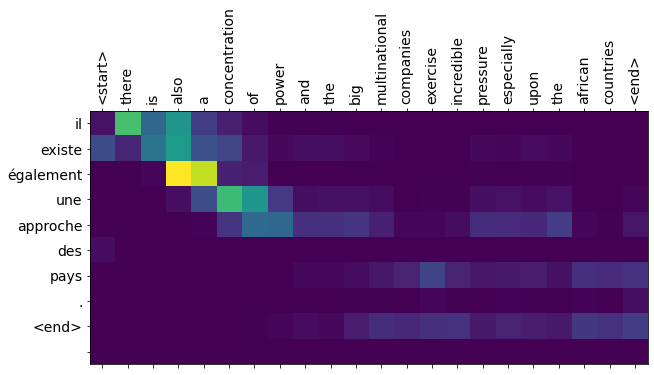

In [56]:
# trying to predict first sentence of validation set
translate(f"there is also a concentration of power and the big multinational companies exercise incredible pressure especially upon the african countries")

In [59]:
# predicting last sentence of validation set
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_val[-1])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_val[-1])

Input Language; index to word mapping
2 ----> <start>
260 ----> women
47 ----> must
20 ----> have
1079 ----> equal
475 ----> pay
15 ----> for
114 ----> work
4 ----> of
1079 ----> equal
832 ----> value
3 ----> <end>

Target Language; index to word mapping
2 ----> <start>
10 ----> les
279 ----> femmes
138 ----> doivent
5 ----> ,
21 ----> pour
16 ----> un
116 ----> travail
6427 ----> équivalent
5 ----> ,
597 ----> obtenir
16 ----> un
3861 ----> salaire
7568 ----> égal
295 ----> celui
11 ----> des
553 ----> hommes
183 ----> !
3 ----> <end>


Input: <start> women must have equal pay for work of equal value <end>
Predicted translation: les femmes . <end> 


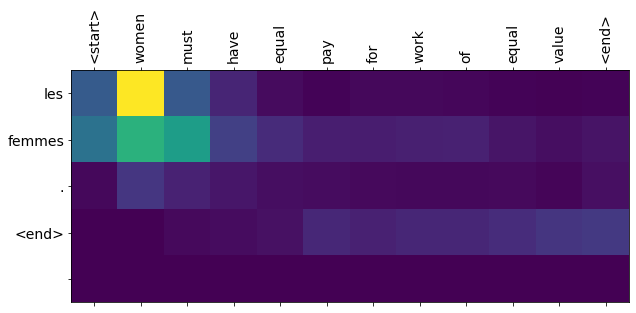

In [60]:
translate(f"women must have equal pay for work of equal value")